# 9. Analyzing Testing Sets

In [33]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib
from repeating_classifier_training_utils import *

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load test set

In [34]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)


original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])
#filtered_eventdata = original_eventdata[test_filtered_indices]
test_energies = original_energies[test_filtered_indices]
test_positions = original_positions[test_filtered_indices]
test_angles = original_angles[test_filtered_indices]
test_labels = original_labels[test_filtered_indices]

## Distribution of event energies

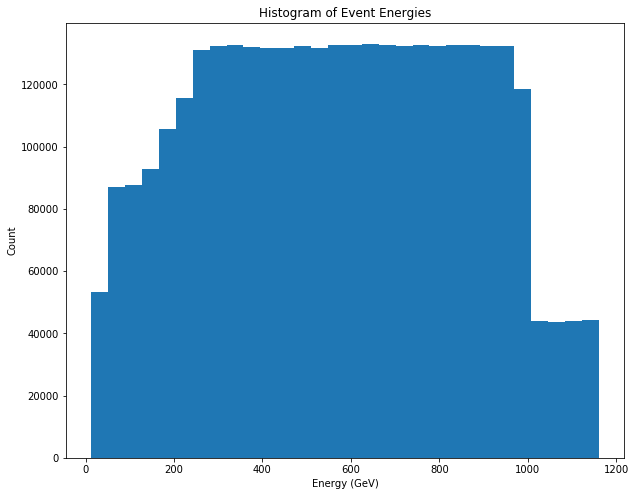

In [35]:
plt.figure(figsize=(10,8))
plt.hist(test_energies,bins=30)
plt.title('Histogram of Event Energies')
plt.ylabel('Count')
plt.xlabel('Energy (GeV)')
plt.show()

## Distribution of event departure angles

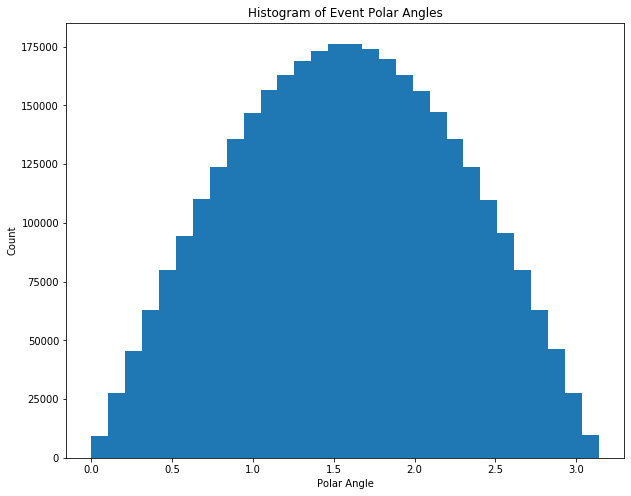

In [36]:
plt.figure(figsize=(10,8))
plt.hist(test_angles[:,0],bins=30)
plt.title('Histogram of Event Polar Angles')
plt.ylabel('Count')
plt.xlabel('Polar Angle')
plt.show()

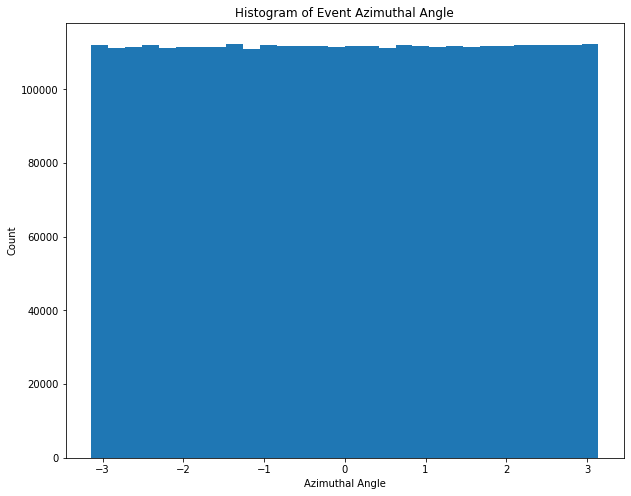

In [37]:
plt.figure(figsize=(10,8))
plt.hist(test_angles[:,1],bins=30)
plt.title('Histogram of Event Azimuthal Angle')
plt.ylabel('Count')
plt.xlabel('Azimuthal Angle')
plt.show()

## Distribution of events throughout the detector volume

In [38]:
test_radius = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]

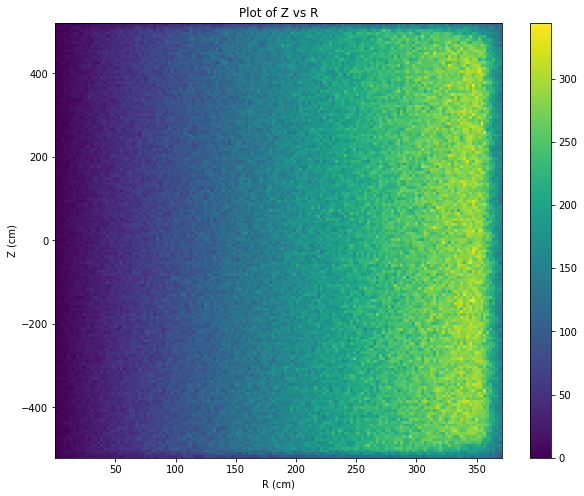

In [35]:
plt.figure(figsize=(10,8))
mat,_,_,im = plt.hist2d(test_radius, test_positions[:,0,1],[150,150])
cbar = plt.colorbar(im)
plt.title('Plot of Z vs R')
plt.ylabel('Z (cm)')
plt.xlabel('R (cm)')
plt.show()

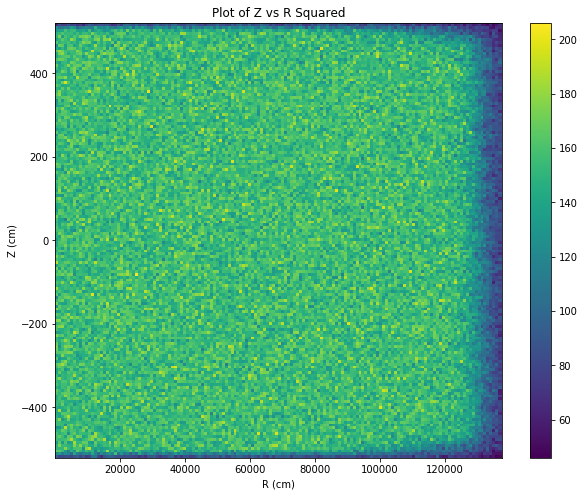

In [34]:
plt.figure(figsize=(10,8))
mat,_,_,im = plt.hist2d(list(map(lambda x : x**2,test_radius)), test_positions[:,0,1],[150,150])
cbar = plt.colorbar(im)
plt.title('Plot of Z vs R Squared')
plt.ylabel('Z (cm)')
plt.xlabel('R Squared (cm)')
plt.show()

## Display some randomly selected event data from edge events

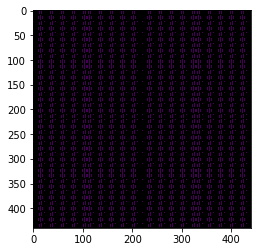

In [46]:
from utils.plot_utils import get_plot_array
fig, ax = plt.subplots(facecolor='w')
cmap = plt.cm.viridis
cmap.set_bad(color='black')

a=get_plot_array(np.ones((40,40,19)))
a = np.ma.masked_where(a < 0.05, a)
ax.imshow(a,
           origin="upper",
           cmap=cmap,
           norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                         clip=True))
plt.savefig('ones.png')
plt.show()

In [39]:
border_event_idxs = []
i = 0
search_idxs = np.random.permutation(len(test_radius))
while len(border_event_idxs) < 10:
    if test_radius[search_idxs[i]] > 360:
        border_event_idxs.append(search_idxs[i])
    i+=1

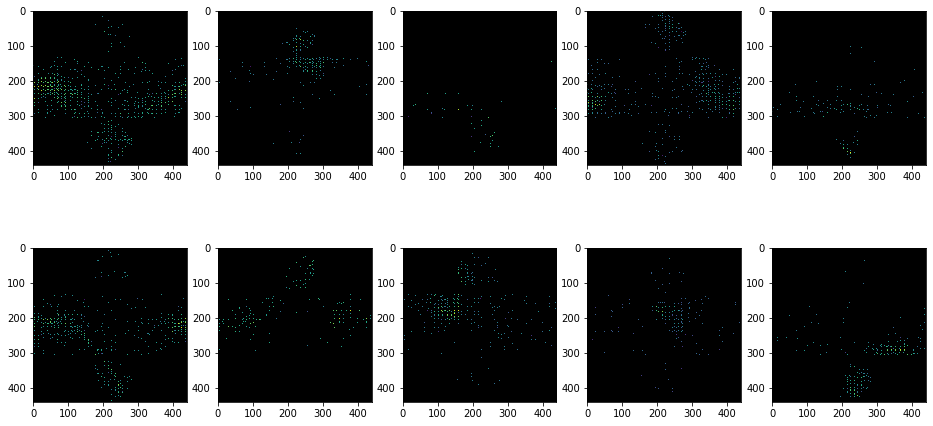

In [40]:
from utils.plot_utils import get_plot_array
fig, axes = plt.subplots(2,5,figsize=(16,8),facecolor='w')
axes = axes.flatten()
cmap = plt.cm.viridis
cmap.set_bad(color='black')
for idx in range(len(axes)):
    ax = axes[idx]
    a=get_plot_array(original_eventdata[border_event_idxs[idx],:,:,0:19])
    a = np.ma.masked_where(a < 0.05, a)
    ax.imshow(a,
               origin="upper",
               cmap=cmap,
               norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                             clip=True))
plt.show()

## Display some randomly selected event data from middle-of-tank events

In [44]:
middle_event_idxs = []
i = 0
search_idxs = np.random.permutation(len(test_radius))
while len(middle_event_idxs) < 10:
    if test_radius[search_idxs[i]] < 50 and np.pi/4 < test_angles[i][0] < 3/4*np.pi:
        middle_event_idxs.append(search_idxs[i])
    i+=1

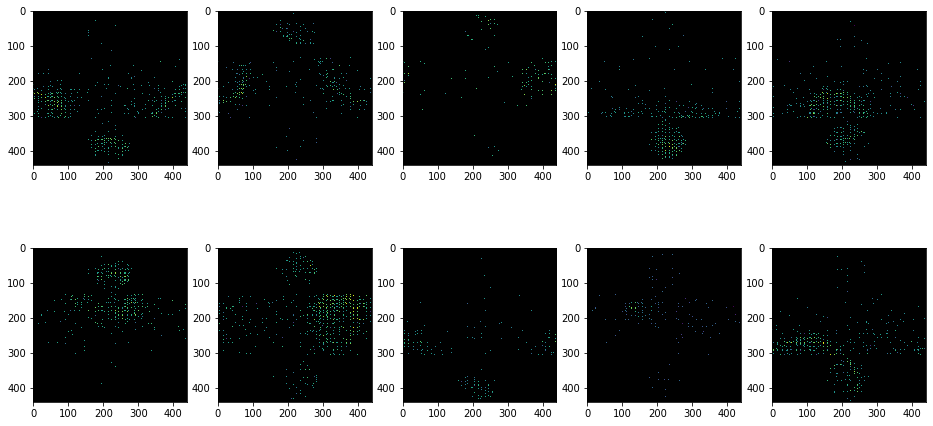

In [45]:
from utils.plot_utils import get_plot_array
fig, axes = plt.subplots(2,5,figsize=(16,8),facecolor='w')
axes = axes.flatten()
cmap = plt.cm.viridis
cmap.set_bad(color='black')
for idx in range(len(axes)):
    ax = axes[idx]
    a=get_plot_array(original_eventdata[middle_event_idxs[idx],:,:,0:19])
    a = np.ma.masked_where(a < 0.05, a)
    ax.imshow(a,
               origin="upper",
               cmap=cmap,
               norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                             clip=True))
plt.show()

In [48]:
filtered_d_to_wall = []
pbar = ProgressBar(widgets=['Calculating Distance to Wall. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=test_positions.shape[0])
pbar.start()
for i in range(test_positions.shape[0]):
    pbar.update(i)
    test_d_to_wall.append(distance_to_wall(test_positions[i][0],test_angles[i]))
pbar.finish()

Calculating Distance to Wall. Progress: 100% [000000000000000000] Time: 0:06:08


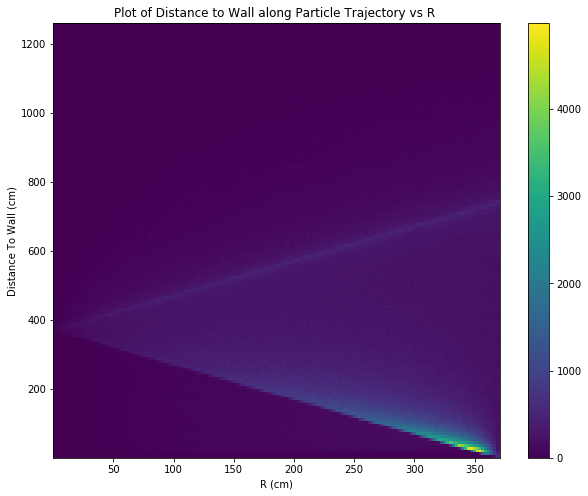

In [98]:
plt.figure(figsize=(10,8))
mat,_,_,im = plt.hist2d(test_radius, test_d_to_wall ,[150,150])
cbar = plt.colorbar(im)
plt.title('Plot of Distance to Wall along Particle Trajectory vs R ')
plt.ylabel('Distance To Wall (cm)')
plt.xlabel('R (cm)')
plt.show()

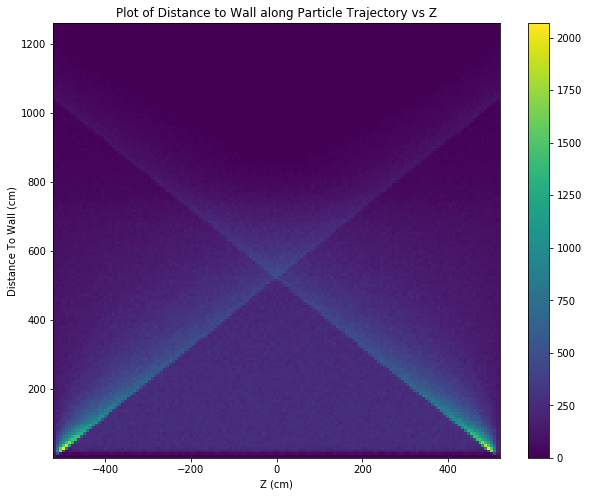

In [99]:
plt.figure(figsize=(10,8))
mat,_,_,im = plt.hist2d(test_positions[:,0,1], test_d_to_wall ,[150,150])
cbar = plt.colorbar(im)
plt.title('Plot of Distance to Wall along Particle Trajectory vs Z')
plt.ylabel('Distance To Wall (cm)')
plt.xlabel('Z (cm)')
plt.show()